# Accurate Extraction with Amazon Comprehend


We will navigate through the following sections in this chapter: -
- Learning Amazon Comprehend for accurate data extraction
- Understanding Document Extraction – IDP stage with Amazon Comprehend
- Understanding custom entities extraction with Amazon Comprehend




In this notebook we will - 

- [Step 1: Setup notebook](#step1)
- [Step 2: Perform entity recocnition with Amazon Comprehend](#step2)
- [Step 3: Train a custom Amazon Comprehend entity recognizer](#step3)


---

# Step 1: Setup notebook <a id="step1"></a>

In this step, we will import some necessary libraries that will be used throughout this notebook. 

In [3]:
import boto3
import botocore
import sagemaker
import time
import os
import json
import datetime
import io
import uuid
import pandas as pd
import numpy as np
from pytz import timezone
from PIL import Image, ImageDraw, ImageFont
import multiprocessing as mp
from pathlib import Path
from textractcaller.t_call import call_textract, Textract_Features
from textractprettyprinter.t_pretty_print import Textract_Pretty_Print, get_string
from trp import Document

# Document
from IPython.display import Image, display, HTML, JSON
from PIL import Image as PImage, ImageDraw


In [4]:
!python -m pip install -q amazon-textract-response-parser --upgrade
!python -m pip install -q amazon-textract-caller --upgrade
!python -m pip install -q amazon-textract-prettyprinter --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


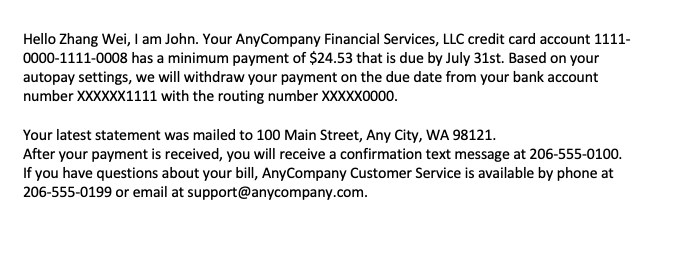

In [6]:
# Document
documentName = "04detectentitiesdoc.png"
display(Image(filename=documentName))

In [7]:
#Extract dense Text from scanned document
# Amazon Textract client
textract = boto3.client('textract')

# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})

# Print detected text
text = ""       
for item in response["Blocks"]:
    if item["BlockType"] == "LINE":
        print ('\033[94m' +  item["Text"] + '\033[0m')
        text = text + " " + item["Text"]


Hello Zhang Wei, I am John. Your AnyCompany Financial Services, LLC credit card account 1111-
0000-1111-0008 has a minimum payment of $24.53 that is due by July 31st. Based on your
autopay settings, we will withdraw your payment on the due date from your bank account
number XXXXXX1111 with the routing number XXXXX0000.
Your latest statement was mailed to 100 Main Street, Any City, WA 98121.
After your payment is received, you will receive a confirmation text message at 206-555-0100.
If you have questions about your bill, AnyCompany Customer Service is available by phone at
206-555-0199 or email at support@anycompany.com.


In [8]:
comprehend=boto3.client('comprehend')
#detect entities
entities = comprehend.detect_entities(LanguageCode="en", Text=text)  
#print(entities)

#Print pre-defined entities of type Person
print("\nPersons identified")
for item in entities["Entities"]:
    if item["Type"] == "PERSON":
        print(item["Text"])

print("\nOrganization identified")
#print pre-defined entities of type Organization
for item in entities["Entities"]:
    if item["Type"] == "ORGANIZATION":
        print(item["Text"])

print("\nQuantities identified")
#print pre-defined entities of type Quantity
for item in entities["Entities"]:
    if item["Type"] == "QUANTITY":
        print(item["Text"])

print("\nLocation identified")
#print pre-defined entities of type Location
for item in entities["Entities"]:
    if item["Type"] == "LOCATION":
        print(item["Text"])


Persons identified
Zhang Wei
John

Organization identified
AnyCompany Financial Services, LLC
AnyCompany Customer Service

Quantities identified
$24.53

Location identified
100 Main Street, Any City, WA 98121


---
# Train a custom Amazon Comprehend entity recognizer <a id="step3"></a>

We will be training a custom [Amazon Comprehend entity recognizer](https://docs.aws.amazon.com/comprehend/latest/dg/custom-entity-recognition.html). There are two ways a custom recognizer can be trained -

- [Using Annotations](https://docs.aws.amazon.com/comprehend/latest/dg/cer-annotation.html)
- [Using Entity Lists](https://docs.aws.amazon.com/comprehend/latest/dg/cer-entity-list.html)

Annotations uses a large set of PDF files that have been annotated. These annotations can be created with service such as Amazon Ground Truth where real human workers can review your files and annotate them. This method is quite involved and if you are interested to learn more refer to [this blog](https://aws.amazon.com/blogs/machine-learning/custom-document-annotation-for-extracting-named-entities-in-documents-using-amazon-comprehend/) and [this blog](https://aws.amazon.com/blogs/machine-learning/extract-custom-entities-from-documents-in-their-native-format-with-amazon-comprehend/). 

In our case, we will use Entity Lists, which is a CSV file that should contain the texts and it's corresponding entity type. The entities in this file is going to be specific to our business needs. For the purposes of this exercise, we have provided an entity list in CSV format in the `/entity-training/` directory called `entitylist.csv`. This file contains a custom entity _Type_ for customer account numbers. We have used _CHECKING_AC_ and _SAVINGS_AC_ as the custom entity types. With this, we ultimately need the custom entity recognizer to recognize the savings and checking bank account numbers.

Let's take a look at our entity list.

In [11]:
entities_df = pd.read_csv('./entity_list.csv', dtype={'Text': object})
entities = entities_df["Type"].unique().tolist()
print(f'Custom entities : {entities}')
print(f'\nTotal Custom entities: {entities_df["Type"].nunique()}')
display(HTML(entities_df.to_html(index=False)))

Custom entities : ['CLOSING_DATE', 'SELLER', 'ADDRESS', 'DUE_AMOUNT']

Total Custom entities: 4


Text,Type
04/11/2022,CLOSING_DATE
Alonso Weiss,SELLER
"7200 Discovery Drive, Chattanooga TN 37416-1757",ADDRESS
$ 3448.12,DUE_AMOUNT
04/20/2022,CLOSING_DATE
Albert Boyd,SELLER
"14840 Central Pike Suite 190,Lebanon, TN 37090",ADDRESS
$ 3327.86,DUE_AMOUNT
07/09/2022,CLOSING_DATE
Hope Lucero,SELLER


Let's train a custom entity recognizer with Amazon Comprehend. In order to train a custom entity recognizer we will need the entity list and the set of documents to train the model. We will use the same set of documents that we used earlier to train the custom classifer for this purpose.

Each custom entity needs atleast 100 samples in the data corpus (documents) for training purposes, meaning you should have atleast a 100 documents containing examples of each of the custom entities in your training dataset. Also, a minimum of 250 entity matches are needed per entity in the entity list to train a model for custom entity recognition. We have provided a training corpus named `entity_training_corpus.csv` which can be used to train the entity recognizer along with the entity list. Note that this corpus was generated the same way we generated training data for training a custom classifier in the first notebook. With these two data sets we will use Amazon Comprehend's [`CreateEntityRecognizer` API](https://docs.aws.amazon.com/comprehend/latest/dg/API_CreateEntityRecognizer.html).

In [13]:
#Upload entity list CSV to S3

entities_key='entity_list.csv'

training_data_key='entity_training_corpus.csv'
data_bucket = "bookidppackt123"
s3=boto3.client('s3')
s3.upload_file(Filename='./entity_list.csv', 
               Bucket=data_bucket, 
               Key=entities_key)

s3.upload_file(Filename='./entity_training_corpus.csv', 
               Bucket=data_bucket, 
               Key=training_data_key)

entities_uri = f's3://{data_bucket}/{entities_key}'
training_data_uri = f's3://{data_bucket}/{training_data_key}'

print(f'Entity List CSV File: {entities_uri}')
print(f'Training Data File: {training_data_uri}')

Entity List CSV File: s3://bookidppackt123/entity_list.csv
Training Data File: s3://bookidppackt123/entity_training_corpus.csv


### Let's now train a custom entity recognizer with this data and the entity list of savings and checking account numbers

In [15]:
# Create a custom entity recognizer
import sagemaker
account_id = boto3.client('sts').get_caller_identity().get('Account')
id = str(datetime.datetime.now().strftime("%s"))

entity_recognizer_name = 'Sample-Entity-Recognizer-IDPBook'
entity_recognizer_version = 'Sample-Entity-Recognizer-IDPBook-v2'
entity_recognizer_arn = ''
create_response = None
role = sagemaker.get_execution_role()
EntityTypes = [ {'Type': entity} for entity in entities]

try:
    create_response = comprehend.create_entity_recognizer(
        InputDataConfig={
            'DataFormat': 'COMPREHEND_CSV',
            'EntityTypes': EntityTypes,
            'Documents': {
                'S3Uri': training_data_uri
            },
            'EntityList': {
                'S3Uri': entities_uri
            }
        },
        DataAccessRoleArn=role,
        RecognizerName=entity_recognizer_name,
        VersionName=entity_recognizer_version,
        LanguageCode='en'
    )
    
    entity_recognizer_arn = create_response['EntityRecognizerArn']
    
    print(f"Comprehend Custom entity recognizer created with ARN: {entity_recognizer_arn}")
except Exception as error:
    if error.response['Error']['Code'] == 'ResourceInUseException':
        print(f'An entity recognizer with the name "{entity_recognizer_name}" already exists.')
        entity_recognizer_arn = f'arn:aws:comprehend:{region}:{account_id}:entity-recognizer/{entity_recognizer_name}/version/{entity_recognizer_version}'
        print(f'The entity recognizer ARN is: "{entity_recognizer_arn}"')
    else:
        print(error)

Comprehend Custom entity recognizer created with ARN: arn:aws:comprehend:us-east-1:044573436347:entity-recognizer/Sample-Entity-Recognizer-IDPBook/version/Sample-Entity-Recognizer-IDPBook-v2
